In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
from IPython.display import display, Math
# phoebe.interactive_checks_off()
# phoebe.interactive_constraints_off()
# phoebe.multiprocessing_on()
# phoebe.mpi_off()
%matplotlib inline

Connection to online passbands at http://tables.phoebe-project.org could not be established.  Check your internet connection or try again later (can manually call phoebe.list_online_passbands(refresh=True) to retry).  If the problem persists and you're using a Mac, you may need to update openssl (see http://phoebe-project.org/help/faq). Original error from urlopen: URLError <urlopen error timed out>


In [2]:
lcV = np.loadtxt('data/lc.V.data')
lcB = np.loadtxt('data/lc.B.data')

rv1 = np.loadtxt('data/rv1.data')
rv2 = np.loadtxt('data/rv2.data')

In [3]:
b = phoebe.default_binary()

b.add_dataset('lc', times = lcV[:,0], fluxes=lcV[:,1], sigmas=lcV[:,2], passband='Johnson:V')
b.add_dataset('lc', times=lcB[:,0], fluxes=lcB[:,1], sigmas=lcB[:,2], passband='Johnson:B')
b.add_dataset('rv')
b['times@rv@primary'], b['rvs@rv@primary'], b['sigmas@rv@primary'] = rv1[:,0], rv1[:,1], rv1[:,2]
b['times@rv@secondary'], b['rvs@rv@secondary'], b['sigmas@rv@secondary'] = rv2[:,0], rv2[:,1], rv2[:,2]

In [4]:
b.set_value_all('distortion_method', 'roche')
b.set_value_all('rv_method', 'dynamical')
b.set_value_all('ntriangles', 3000)
b.set_value_all('irrad_method', 'horvat') # we enable irradiation again for the final MCMCs

In [5]:
b.add_server('remoteslurm', crimpl_name='terra',
             conda_env='phoebe_2.4dev',
             nprocs=96, install_deps=False, walltime=48,
             server='terra', overwrite=True)

<ParameterSet: 11 parameters | qualifiers: use_conda, slurm_job_name, nprocs, install_deps, conda_env, isolate_env, crimpl_name, mail_user, use_mpi, mail_type, walltime>

In [6]:
b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.add_constraint('teffratio')

b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('teffratio', solve_for='teff@secondary')
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')
b.flip_constraint('asini@binary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = {asini@binary@component} / (sin({incl@binary@component})) (solar units) => 5.3 solRad>

In [7]:
twigs = ['incl@binary@orbit@component', 'teffratio@binary@orbit@component',
       'requivratio@binary@orbit@component',
       'requivsumfrac@binary@orbit@component',
       'esinw@binary@orbit@component', 'ecosw@binary@orbit@component',
       'q@binary@orbit@component', 'asini@binary@orbit@component',
       'vgamma@system', 'teff@primary@star@component',
       'pblum@primary@lc01@lc@dataset', 'pblum@primary@lc02@lc@dataset',
       'gravb_bol@primary@star@component',
       'gravb_bol@secondary@star@component',
       'period@binary@orbit@component',
       't0_supconj@binary@orbit@component', 'sigmas_lnf@lc01@lc@dataset',
       'sigmas_lnf@lc02@lc@dataset', 'sigmas_lnf@primary@rv01@rv@dataset',
       'sigmas_lnf@secondary@rv01@rv@dataset']

values = np.loadtxt('data/after_noisenuis_values.txt')

In [8]:
for twig, value in zip(twigs, values):
    twig = twig.removesuffix('@component')
    twig = twig.removesuffix('@system')
    twig = twig.removesuffix('@dataset')
    
    if twig in ['gravb_bol@primary@star', 'gravb_bol@secondary@star']:
        pass
    else:
        sigma = np.max([value[1]-value[0], value[2]-value[1]])
        b.set_value(twig, value[1])
        b.add_distribution(twig, phoebe.gaussian(value[1], sigma), distribution='sample_init')

b.add_distribution('gravb_bol@primary', phoebe.gaussian(0.32, 0.03), distribution='sample_init')
b.add_distribution('gravb_bol@secondary', phoebe.gaussian(0.32, 0.03), distribution='sample_init')
b.add_distribution('irrad_frac_refl_bol@primary', phoebe.gaussian(0.6, 0.03), distribution='sample_init')
b.add_distribution('irrad_frac_refl_bol@secondary', phoebe.gaussian(0.6, 0.03), distribution='sample_init')

<ParameterSet: 1 parameters>

In [9]:
b.add_distribution('incl@binary', phoebe.uniform(80,90), distribution='upriors')
b.add_distribution('teffratio', phoebe.uniform(0.5,1.5), distribution='upriors')
b.add_distribution('requivratio', phoebe.uniform(0.1,1.), distribution='upriors')
b.add_distribution('requivsumfrac', phoebe.uniform(0.05,0.5), distribution='upriors')
b.add_distribution('esinw', phoebe.uniform(-0.5,0.5), distribution='upriors')
b.add_distribution('ecosw', phoebe.uniform(-0.5,0.5), distribution='upriors')
b.add_distribution('q@binary', phoebe.uniform(0.5,1.5), distribution='upriors')
b.add_distribution('asini@binary', phoebe.uniform(1,20), distribution='upriors')
b.add_distribution('vgamma@system', phoebe.uniform(100,300), distribution='upriors')
b.add_distribution('teff@primary', phoebe.uniform(3500,15000), distribution='upriors')
b.add_distribution('pblum@primary@lc01', phoebe.uniform(5,20), distribution='upriors')
b.add_distribution('pblum@primary@lc02', phoebe.uniform(5,20), distribution='upriors')
b.add_distribution('period@binary', phoebe.uniform(2.3,2.4), distribution='upriors')
b.add_distribution('t0_supconj@binary', phoebe.uniform(2.2,2.5), distribution='upriors')
b.add_distribution('gravb_bol@primary', phoebe.gaussian(0.32, 0.03), distribution='upriors')
b.add_distribution('gravb_bol@secondary', phoebe.gaussian(0.32, 0.03), distribution='upriors')
b.add_distribution('irrad_frac_refl_bol@primary', phoebe.gaussian(0.6, 0.03), distribution='upriors')
b.add_distribution('irrad_frac_refl_bol@secondary', phoebe.gaussian(0.6, 0.03), distribution='upriors')

<ParameterSet: 1 parameters>

In [10]:
b.run_compute(use_server='terra', model='init_model')

# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: received ssh error, waiting 5s then retrying
# crimpl: received ssh error, waiting 10s then retrying
# crimpl: ssh command succeeded
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/angela/crimpl/crimpl-job-2022.05.15-20.05.24/*"
# crimpl: ssh terra "mkdir -p ~/crimpl"
# crimpl: scp exportpath.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-2022.05.15-20.05.24/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p /home/users/angela/crimpl/crimpl-job-2022.05.15-20.05.24"
# crimpl: scp crimpl_submit_script.sh /Users/angela/Documents/WORK/PHOETTING/phoetting-paper/FINAL_NOTEBOOKS_RESULTS/_piVmtPldnuapoWKDmRBWlwVaowkjLa.py terra:/home/users/angela/c

<ParameterSet: 9 parameters | kinds: rv, lc>

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


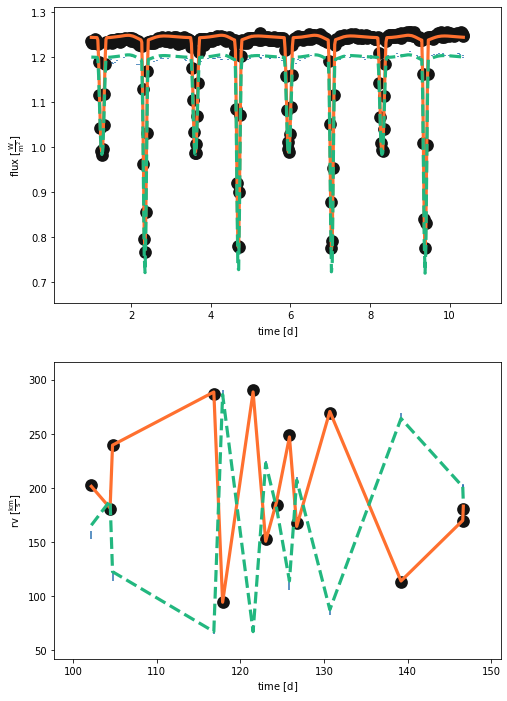

(<autofig.figure.Figure | 2 axes | 8 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [11]:
b.plot(show=True)

In [12]:
b.save('bundles/pre_gps.bundle')

'bundles/pre_gps.bundle'